# Building Recommender System from scratch

##### Always import Numpy and Pandas libraries to manipulate our dataset.
##### Numpy and Pandas libraries are the essential libraries for almost every Data Science project

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

## Step 1: Import necessary libraries for plotting 

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

## Step 2: Load the Datasets

#### We have to load our rating.csv and anime.csv files.

In [3]:
#Loading dataset and viewing first 5 rows of rating.csv

ratings = pd.read_csv('/Users/AZM/Desktop/Dataset/rating.csv')
ratings.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [4]:
#Loading dataset and viewing first 5 rows of anime.csv

animes = pd.read_csv('/Users/AZM/Desktop/Dataset/anime.csv')
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


## Step 3: Exploratory Data Analysis (EDA)
##### Need to get:
* Number of ratings
* Number of unique anime_id's 
* Number of unique users 
* Average number of ratings per user
* Average number of ratings per anime 

In [5]:


n_ratings = len(ratings)
n_animes = ratings['anime_id'].nunique()
n_users = ratings['user_id'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique anime_id's: {n_animes}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users, 2)}")
print(f"Average number of ratings per anime: {round(n_ratings/n_animes, 2)}")

Number of ratings: 7813737
Number of unique anime_id's: 11200
Number of unique users: 73515
Average number of ratings per user: 106.29
Average number of ratings per anime: 697.66


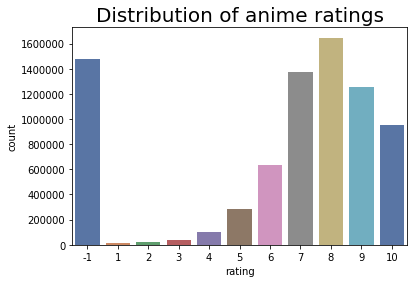

In [6]:
#Plotting distribution of anime ratings

sns.countplot(x="rating", data=ratings, palette="deep")
plt.title("Distribution of anime ratings", fontsize=20)
plt.show()

 From the plot I see rating "-1" is prevalent.     I want to replace "-1" rating with "0", so that it doesn't impact our calculations of mean, etc.

In [7]:
#replacing -1 with 0
ratings.loc[ratings['rating'] == -1, 'rating'] = 0
ratings.head()

,user_id,anime_id,rating
0,1,20,0
1,1,24,0
2,1,79,0
3,1,226,0
4,1,241,0


In [8]:
#Mean global rating:
#Mean rating per user:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('user_id')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 6.33.
Mean rating per user: 6.82.


###### Which anime has the lowest and highest average rating?

In [9]:
#Getting lowest rated anime

mean_ratings = ratings.groupby('anime_id')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
animes[animes['anime_id'] == lowest_rated]

,anime_id,name,genre,type,episodes,rating,members
4980,1396,Future GPX Cyber Formula: Early Days Renewal,"Drama, Sci-Fi, Shounen, Sports",OVA,2,6.58,338


In [10]:
#Getting highest rated anime

highest_rated = mean_ratings['rating'].idxmax()
animes[animes['anime_id'] == highest_rated]

,anime_id,name,genre,type,episodes,rating,members
8364,31211,Choegang Top Plate,"Action, Comedy, Kids, Sports",TV,26,7.2,86


##### We see that "Future GPX Cyber Formula: Early Days Renewa"l and "Choegang Top Plate" have the lowest and highest ratings. But both of them have low number of people who rated them (seen in the column "members").
#### To solve the issue with biased evaluation of lowest and highest anime, let's use Bayesian Average technique

In [11]:
#pre-processing data

anime_stats = ratings.groupby('anime_id')[['rating']].agg(['count', 'mean'])
anime_stats.columns = anime_stats.columns.droplevel()

In [12]:
#Creating a function bayesian_avg()

C = anime_stats['count'].mean()
m = anime_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('anime_id')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['anime_id', 'bayesian_avg']
anime_stats = anime_stats.merge(bayesian_avg_ratings, on='anime_id')

In [13]:
anime_stats = anime_stats.merge(animes[['anime_id', 'name']])
anime_stats.sort_values('bayesian_avg', ascending=False).head()

,anime_id,count,mean,bayesian_avg,name
5673,9253,19283,8.237359,8.100195,Steins;Gate
3965,5114,24574,8.154269,8.048116,Fullmetal Alchemist: Brotherhood
3531,4181,17854,7.966114,7.828585,Clannad: After Story
2651,2904,24242,7.894563,7.794262,Code Geass: Hangyaku no Lelouch R2
6466,11061,8575,8.052128,7.770505,Hunter x Hunter (2011)


In [14]:
#Printing sorted values of animes according to bayesian average.

anime_stats.sort_values('bayesian_avg', ascending=True).head()

,anime_id,count,mean,bayesian_avg,name
385,413,1131,2.236958,3.027477,Hametsu no Mars
8044,19315,2677,3.363840,3.559241,Pupa
2929,3287,237,1.839662,3.682868,Tenkuu Danzai Skelter+Heaven
7469,16608,231,2.670996,3.901568,Shitcom
3856,4866,1397,3.778096,3.954928,Pico x CoCo x Chico


After using Bayesian Average, we can see how the result makes much more sense now. The top animes are now actually well known ones with relevant number of people, who rated the animes.(see the column "count").

### Exploring Genres
#### Task for exploring genres: Count each unique genre from column "genre".

#### Pre-process

In [15]:
#I had to fill the NaN-s in order to make my dataset ready for exploration
#filling na-s with "" empty string

animes['genre']=animes['genre'].fillna("")

In [16]:
#converting column "genre" to string
#It's done before converting it into list

animes['genre'] = [''.join(map(str, l)) for l in animes['genre']]
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [17]:
#converting column "genre" from string to list
#It's done before using a function Counter that will count our genres.

animes['genre'] = animes['genre'].apply(lambda x: x.split(","))
animes.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"[Drama, Romance, School, Supernatural]",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"[Action, Adventure, Drama, Fantasy, Magic,...",TV,64,9.26,793665
2,28977,Gintama°,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.25,114262
3,9253,Steins;Gate,"[Sci-Fi, Thriller]",TV,24,9.17,673572
4,9969,Gintama&#039;,"[Action, Comedy, Historical, Parody, Samur...",TV,51,9.16,151266


In [18]:
#Counting each unique genre

from collections import Counter

genre_frequency = Counter(g for genres in animes['genre'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 83 genres.


Counter({'Drama': 991,
         ' Romance': 1371,
         ' School': 1170,
         ' Supernatural': 1023,
         'Action': 2845,
         ' Adventure': 891,
         ' Drama': 1025,
         ' Fantasy': 1815,
         ' Magic': 716,
         ' Military': 405,
         ' Shounen': 1663,
         ' Comedy': 1452,
         ' Historical': 636,
         ' Parody': 393,
         ' Samurai': 146,
         ' Sci-Fi': 1986,
         'Sci-Fi': 84,
         ' Thriller': 86,
         'Comedy': 3193,
         ' Sports': 499,
         ' Super Power': 464,
         ' Space': 380,
         ' Slice of Life': 1117,
         ' Mecha': 826,
         'Adventure': 1457,
         ' Music': 457,
         ' Mystery': 421,
         ' Seinen': 536,
         'Fantasy': 494,
         ' Martial Arts': 260,
         ' Vampire': 101,
         ' Shoujo': 590,
         ' Horror': 295,
         ' Police': 196,
         ' Psychological': 206,
         'Mystery': 74,
         'Psychological': 23,
         ' Demons': 2

We see that there are 83 unique genres.

In [19]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Comedy', 3193), ('Action', 2845), (' Sci-Fi', 1986), (' Fantasy', 1815), (' Shounen', 1663)]


## Step 4: Data Pre-processing

### Building a Recommender system using Collaborative Filtering technique

#### This technique is based on the premise that similar people like similar things.

* The first step is to transform our data into a user-item matrix, also known as a "utility" matrix. In this matrix, rows represent users and columns represent animes. 

* The create_X() function outputs a sparse matrix X with four mapper dictionaries:

user_mapper: maps user id to user index
anime_mapper: maps anime id to anime index
user_inv_mapper: maps user index to user id
anime_inv_mapper: maps anime index to anime id
We need these dictionaries because they map which row/column of the utility matrix corresponds to which user/anime id.

Our X (user-item) matrix is a scipy.sparse.csr_matrix which stores the data sparsely.

In [20]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe containing 3 columns (user_id, anime_id, rating)
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        anime_mapper: dict that maps anime id's to anime indices
        anime_inv_mapper: dict that maps anime indices to anime id's
    """
    M = df['user_id'].nunique()
    N = df['anime_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(M))))
    anime_mapper = dict(zip(np.unique(df["anime_id"]), list(range(N))))
    
    user_inv_mapper = dict(zip(list(range(M)), np.unique(df["user_id"])))
    anime_inv_mapper = dict(zip(list(range(N)), np.unique(df["anime_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    item_index = [anime_mapper[i] for i in df['anime_id']]

    X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))
    
    return X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper

X, user_mapper, anime_mapper, user_inv_mapper, anime_inv_mapper = create_X(ratings)

Here, we calculate sparsity by dividing the number of stored elements by total number of elements. The number of stored (non-empty) elements in our matrix is equivalent to the number of ratings in our dataset.

In [21]:
#Evaluating sparsity
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 0.95%


Since our matrix is sparse for .95%, let's explore the numbers of ratings. We do it in order to know how the ratings are distributed

In [22]:
n_ratings_per_user = X.getnnz(axis=1)

print(f"Most active user rated {n_ratings_per_user.max()} animes.")
print(f"Least active user rated {n_ratings_per_user.min()} animes.")

Most active user rated 10227 animes.
Least active user rated 1 animes.


In [23]:
n_ratings_per_anime = X.getnnz(axis=0)

print(f"Most rated anime has {n_ratings_per_anime.max()} ratings.")
print(f"Least rated anime has {n_ratings_per_anime.min()} ratings.")

Most rated anime has 39340 ratings.
Least rated anime has 1 ratings.


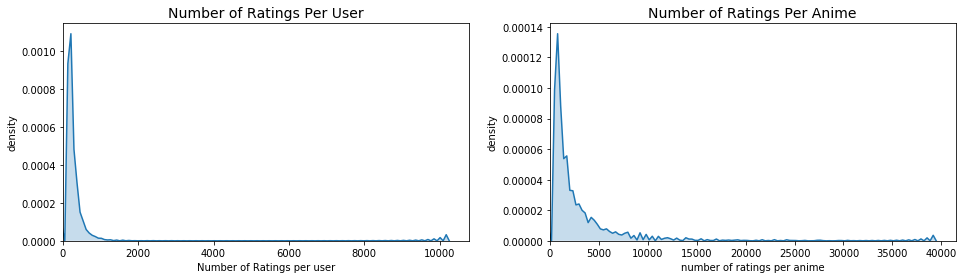

In [24]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("Number of Ratings per user")
plt.ylabel("density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_anime, shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Anime", fontsize=14)
plt.xlabel("number of ratings per anime")
plt.ylabel("density")
plt.show()

#### We see that the numbers are distribured very naturally:

* Mostly each person did not rate thousands of animes.
* Most of the animes have less than 5000 ratings. 

#### Normalizing our data: we need to do it in order to make our data scaled evenly. (For more info on normalization, try to google the concept of normalizing data)

In [25]:
#Normalizing our data
# normalize the data attributes
from sklearn import preprocessing

X_norm = preprocessing.normalize(X)

## Step 5: Item to item Recommendations with k-Nearest Neighbors (kNN) according to genre

In [26]:
from sklearn.neighbors import NearestNeighbors

def find_similar_animes(anime_id, X, anime_mapper, anime_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given anime id.
    
    Args:
        animee_id: id of the anime of interest
        X: user-item utility matrix
        k: number of similar animes to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar anime ID's
    """
    X = X.T
    neighbour_ids = []
    
    anime_ind = anime_mapper[anime_id]
    anime_vec = X[anime_ind]
    if isinstance(anime_vec, (np.ndarray)):
        anime_vec = anime_vec.reshape(1,-1)
    # use k+1 since kNN output includes the anime_id of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(anime_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(anime_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [27]:
similar_animes = find_similar_animes(1, X_norm, anime_mapper, anime_inv_mapper, k=10)
similar_animes

[5, 205, 6, 227, 30, 47, 43, 2001, 467]

find_similar_animes() takes in a anime_id and X matrix, and outputs a list of $k$ animes that are similar to the anime_id of interest.

#### Let's see how it works in action. We will first create another mapper that maps anime_id to title so that our results are interpretable.
Get recommendations if the user watched Naruto (id in dataset = 20)

In [28]:
#Recommendations if the user watched Naruto (id in dataset = 20).

anime_titles = dict(zip(animes['anime_id'], animes['name']))

anime_id = 20

similar_animes = find_similar_animes(anime_id, X_norm, anime_mapper, anime_inv_mapper, metric='cosine', k=10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
    print(anime_titles[i])

Because you watched Naruto:
Death Note
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
Fullmetal Alchemist
Dragon Ball Z
Bleach
Naruto: Shippuuden Movie 1
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!
Dragon Ball
Code Geass: Hangyaku no Lelouch


The results above show the 10 animes that are most similar to Naruto. 
Most of the animes recommended seem to be famous animes or animes related to Naruto itself. It's a pretty reasonable recommendation list.

## Step 6: Handling the cold-start problem

Collaborative filtering relies solely on user-item interactions within the utility matrix. The issue with this approach is that brand new users or items with no iteractions get excluded from the recommendation system. This is called the cold start problem. Content-based filtering is a way to handle this problem by generating recommendations based on user and item features.

First, we need to convert the genres column into binary features. Each genre will have its own column in the dataframe, and will be populated with 0 or 1.

In [29]:
n_animes = animes['anime_id'].nunique()
print(f"There are {n_animes} unique animes in our animes dataset.")

There are 12294 unique animes in our animes dataset.


In [30]:
#Creating genres dataframe

genres = set(g for G in animes['genre'] for g in G)

for g in genres:
    animes[g] = animes.genre.transform(lambda x: int(g in x))
    
anime_genres = animes.drop(columns=['anime_id', 'name','genre'])


In [31]:
#removing irrelevant columns
del anime_genres['type']
del anime_genres['episodes']
del anime_genres['rating']
del anime_genres['members']
del anime_genres['']

In [32]:
anime_genres.head()

,Kids,Drama,Mystery,Samurai,Comedy,Game,Space,Vampire,Adventure,Super Power,...,Psychological,Supernatural,Fantasy,Shounen,Sci-Fi,Military,Hentai,Ecchi,Action,School
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


We use cosine_similarity method to measure the distance of animes from each other. (Cosine similarity is one of the methods to measure the difference of points(animes in our case) )

In [33]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(anime_genres, anime_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (12294, 12294)


In [34]:
def anime_finder(title):
    return animes[animes['name'].str.contains(title)]['name'].tolist()

anime_finder('Naruto')

['Boruto: Naruto the Movie',
 'Naruto: Shippuuden',
 'The Last: Naruto the Movie',
 'Naruto: Shippuuden Movie 6 - Road to Ninja',
 'Naruto',
 'Boruto: Naruto the Movie - Naruto ga Hokage ni Natta Hi',
 'Naruto: Shippuuden Movie 5 - Blood Prison',
 'Naruto x UT',
 'Naruto: Shippuuden Movie 4 - The Lost Tower',
 'Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsugu Mono',
 'Naruto: Shippuuden Movie 1',
 'Naruto: Shippuuden Movie 2 - Kizuna',
 'Naruto Shippuuden: Shippuu! &quot;Konoha Gakuen&quot; Den',
 'Naruto: Honoo no Chuunin Shiken! Naruto vs. Konohamaru!!',
 'Naruto SD: Rock Lee no Seishun Full-Power Ninden',
 'Naruto Shippuuden: Sunny Side Battle',
 'Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!',
 'Naruto Soyokazeden Movie: Naruto to Mashin to Mitsu no Onegai Dattebayo!!',
 'Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!',
 'Naruto: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo! Special: Konoha Annual Sports Festival',
 'Naruto Movie 3: D

### Seeing the content based recommender in action

In [35]:
anime_idx = dict(zip(animes['name'], list(animes.index)))
title = anime_finder('Naruto')[0]
n_recommendations = 10

idx = anime_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_animes = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
animes['name'].iloc[similar_animes]

Recommendations for Boruto: Naruto the Movie:


615                                    Naruto: Shippuuden
841                                                Naruto
1103    Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343                                          Naruto x UT
1472          Naruto: Shippuuden Movie 4 - The Lost Tower
1573    Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...
2458                 Naruto Shippuuden: Sunny Side Battle
2997    Naruto Soyokazeden Movie: Naruto to Mashin to ...
175                                Katekyo Hitman Reborn!
7628                              Kyutai Panic Adventure!
Name: name, dtype: object

We can see in this recommender that even if the new user comes, we are able to recommend the animes that person wants.

## Let's test our recommenders one more time:

## Firstly, let's test Content Based recommender.

In [36]:
#Find the ID of interested anime
animes.loc[animes['name'] == "Naruto"]

,anime_id,name,genre,type,episodes,rating,members,,Kids,Drama,...,Psychological,Supernatural,Fantasy,Shounen,Sci-Fi,Military,Hentai,Ecchi,Action,School
841,20,Naruto,"[Action, Comedy, Martial Arts, Shounen, Su...",TV,220,7.81,683297,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### If new user wants to get recommendations for "Naruto", then:

In [37]:
#Content Based recommender

anime_idx = dict(zip(animes['name'], list(animes.index)))
title = anime_finder('Naruto')[0]
n_recommendations = 10

idx = anime_idx[title]
sim_scores = list(enumerate(cosine_sim[idx]))
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
sim_scores = sim_scores[1:(n_recommendations+1)]
similar_animes = [i[0] for i in sim_scores]

print(f"Recommendations for {title}:")
animes['name'].iloc[similar_animes]

Recommendations for Boruto: Naruto the Movie:


615                                    Naruto: Shippuuden
841                                                Naruto
1103    Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343                                          Naruto x UT
1472          Naruto: Shippuuden Movie 4 - The Lost Tower
1573    Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...
2458                 Naruto Shippuuden: Sunny Side Battle
2997    Naruto Soyokazeden Movie: Naruto to Mashin to ...
175                                Katekyo Hitman Reborn!
7628                              Kyutai Panic Adventure!
Name: name, dtype: object

### Once user finished watching "Naruto", system recommends other related animes

In [38]:
#Collaborative Filtering Recommender
#Recommendations if the user watched Naruto (id in dataset = 20).

anime_titles = dict(zip(animes['anime_id'], animes['name']))

anime_id = 20

similar_animes = find_similar_animes(anime_id, X_norm, anime_mapper, anime_inv_mapper, metric='cosine', k=10)
anime_title = anime_titles[anime_id]

print(f"Because you watched {anime_title}:")
for i in similar_animes:
    print(anime_titles[i])

Because you watched Naruto:
Death Note
Naruto Movie 1: Dai Katsugeki!! Yuki Hime Shinobu Houjou Dattebayo!
Fullmetal Alchemist
Dragon Ball Z
Bleach
Naruto: Shippuuden Movie 1
Naruto Movie 2: Dai Gekitotsu! Maboroshi no Chiteiiseki Dattebayo!
Dragon Ball
Code Geass: Hangyaku no Lelouch
